In [3]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt 
import geopandas as gp
import pandas as pd

# Visualizing and Measuring Road Curvature (Tortuosity)

In [4]:
ph_city = "Baguio, Philippines"
eu_city = "Zurich, Switzerland"

In [5]:
G_ph = ox.graph_from_place(ph_city, network_type="drive")
G_eu = ox.graph_from_place(eu_city, network_type="drive")

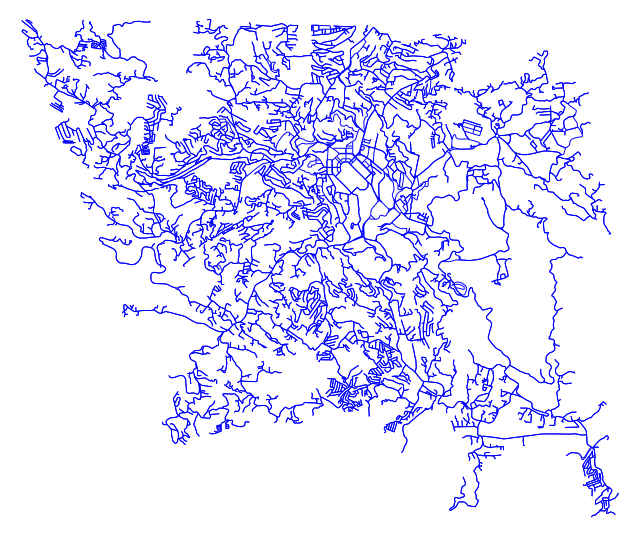

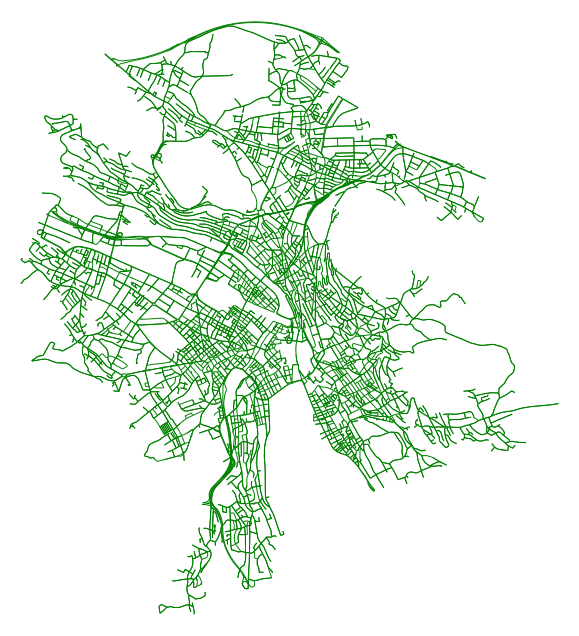

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
ox.plot_graph(G_ph, bgcolor='white', node_size=0, edge_color='blue', edge_linewidth=0.7)
ox.plot_graph(G_eu, bgcolor='white', node_size=0, edge_color='green', edge_linewidth=0.7)

In [7]:
def add_curvature(graph):
    for u, v, key, data in graph.edges(keys=True, data=True):
        if 'geometry' in data:
            length = data['length']
            x1, y1 = graph.nodes[u]['x'], graph.nodes[u]['y']
            x2, y2 = graph.nodes[v]['x'], graph.nodes[v]['y']
            straight = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
            data['curvature'] = length / straight if straight > 0 else 1
        else:
            data['curvature'] = 1  # straight road segment
    return graph

G_ph = add_curvature(G_ph)
G_eu = add_curvature(G_eu)

In [8]:
edges_ph = ox.graph_to_gdfs(G_ph, nodes=False)
edges_eu = ox.graph_to_gdfs(G_eu, nodes=False)

# Curved Roads Comparison

In [9]:
print("Average curvature (Philippines):", edges_ph['curvature'].mean())
print("Average curvature (Europe):", edges_eu['curvature'].mean())

Average curvature (Philippines): 103184.43669527813
Average curvature (Europe): 85593.12073754892


Text(0.5, 1.0, 'Most Curved Roads in Baguio')

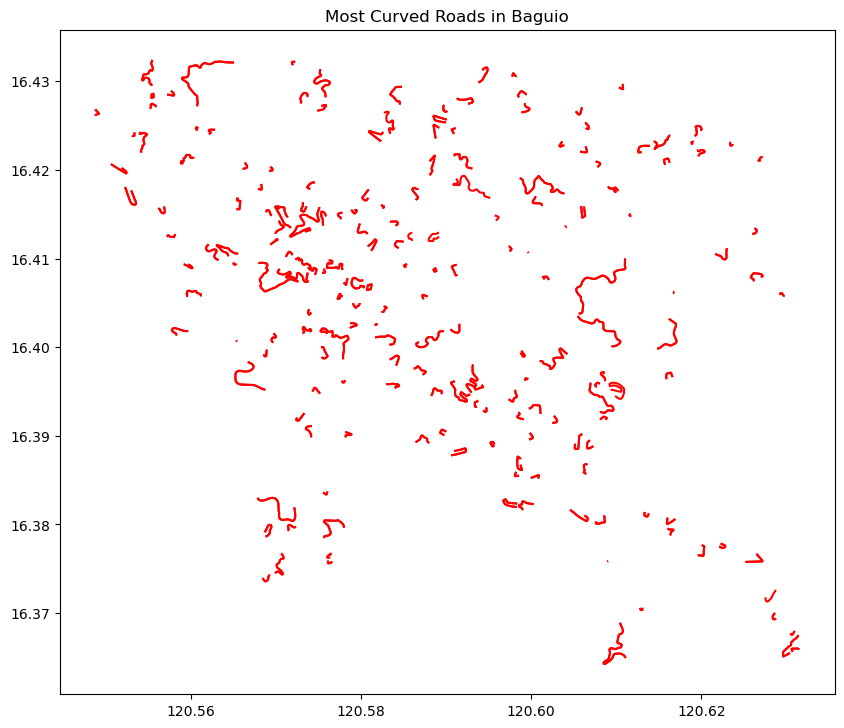

In [10]:
curvy_roads_ph = edges_ph[edges_ph['curvature'] > edges_ph['curvature'].quantile(0.95)]
curvy_roads_ph.plot(figsize=(10, 10), color='red')
plt.title("Most Curved Roads in Baguio")

Text(0.5, 1.0, 'Most Curved Roads in Zurich')

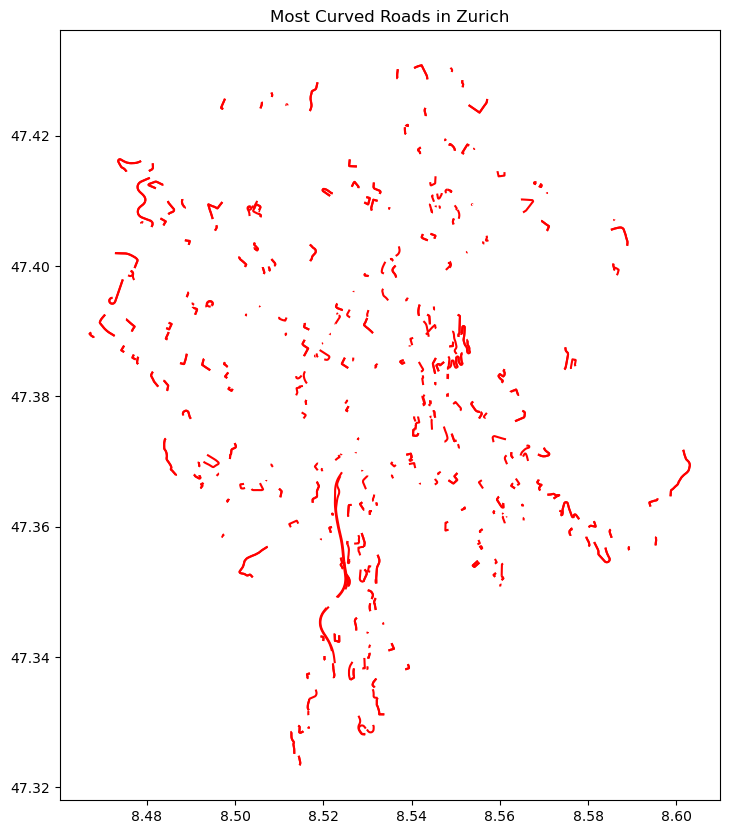

In [11]:
curvy_roads_eu = edges_eu[edges_eu['curvature'] > edges_eu['curvature'].quantile(0.95)]
curvy_roads_eu.plot(figsize=(10, 10), color='red')
plt.title("Most Curved Roads in Zurich")

Text(0.5, 1.0, 'Curvature Distribution')

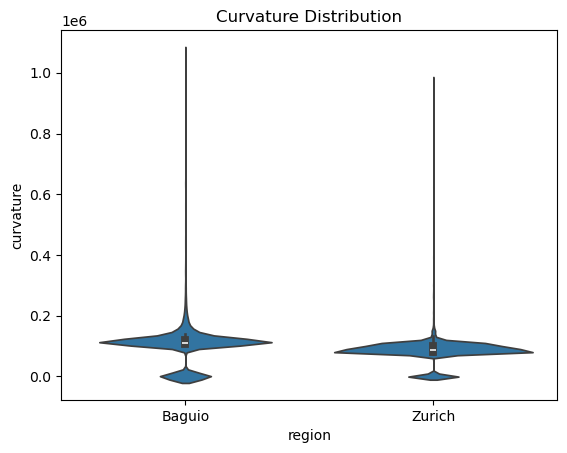

In [12]:
import seaborn as sns

edges_ph['region'] = 'Baguio'
edges_eu['region'] = 'Zurich'

combined = pd.concat([edges_ph[['curvature', 'region']], edges_eu[['curvature', 'region']]])

sns.violinplot(x='region', y='curvature', data=combined)
plt.title("Curvature Distribution")

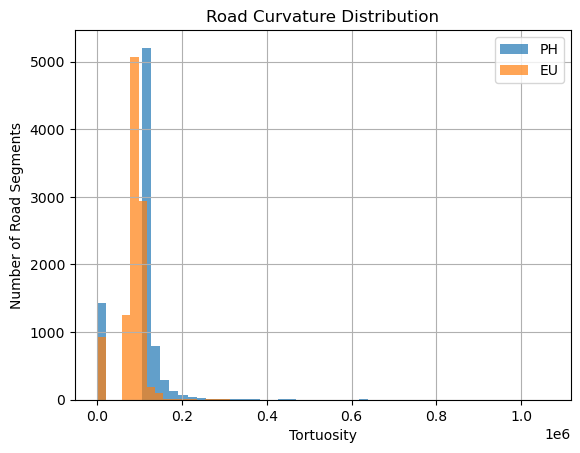

In [13]:
edges_ph['curvature'].hist(alpha=0.7, label='PH', bins=50)
edges_eu['curvature'].hist(alpha=0.7, label='EU', bins=50)
plt.legend()
plt.title("Road Curvature Distribution")
plt.xlabel("Tortuosity")
plt.ylabel("Number of Road Segments")
plt.show()

In [14]:
graph_ph = ox.graph_from_place("Baguio, Benguet, Philippines", network_type='drive')

# Add elevation from your DEM file
dem_path = "baguio.tif"
graph_ph = ox.elevation.add_node_elevations_raster(graph_ph, dem_path)

# Add grade (slope) to each edge
graph_ph = ox.elevation.add_edge_grades(graph_ph)

In [15]:
edges = ox.graph_to_gdfs(graph_ph, nodes=False)
edges['abs_grade'] = edges['grade'].abs()

# Example: correlation with curvature
edges['curvature'] = edges['length'] / edges['geometry'].apply(lambda g: g.length if g.length != 0 else 1)

correlation = edges[['curvature', 'abs_grade']].corr()
print(correlation)

           curvature  abs_grade
curvature   1.000000  -0.048142
abs_grade  -0.048142   1.000000


# Steep Roads Comparison

Text(0.5, 1.0, 'Steep Road Segments in Baguio')

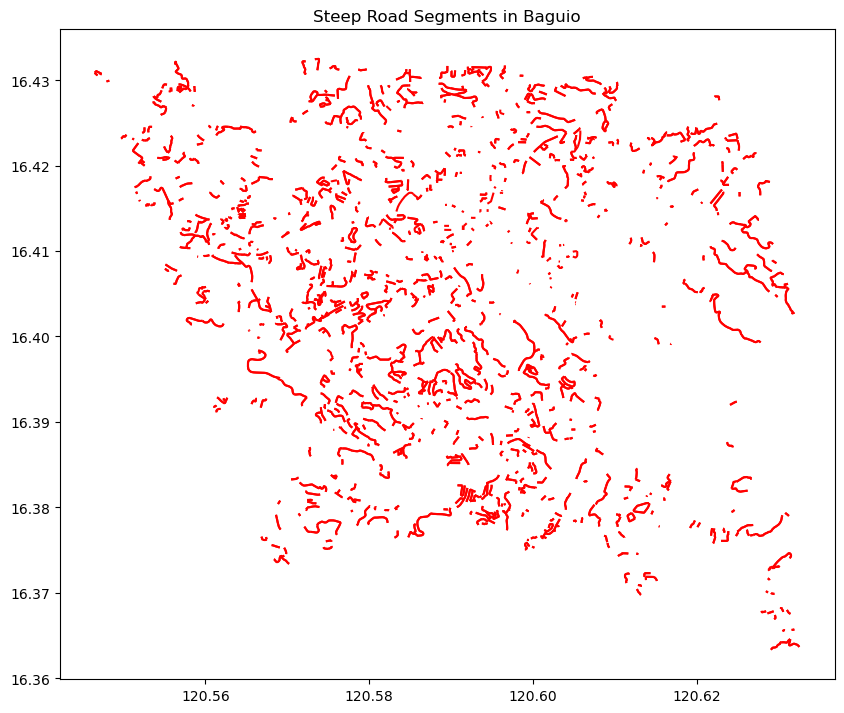

In [16]:
steep = edges[edges['abs_grade'] > 0.1]  # 10% grade
steep.plot(color='red', figsize=(10,10))
plt.title("Steep Road Segments in Baguio")

In [17]:
graph_eu = ox.graph_from_place("Zurich, Switzerland", network_type='drive')

# Add elevation from your DEM file
dem_path = "zurich.tif"
graph_eu = ox.elevation.add_node_elevations_raster(graph_eu, dem_path)

# Add grade (slope) to each edge
graph_eu = ox.elevation.add_edge_grades(graph_eu)

In [18]:
edges = ox.graph_to_gdfs(graph_eu, nodes=False)
edges['abs_grade'] = edges['grade'].abs()

# Example: correlation with curvature
edges['curvature'] = edges['length'] / edges['geometry'].apply(lambda g: g.length if g.length != 0 else 1)

correlation = edges[['curvature', 'abs_grade']].corr()
print(correlation)

           curvature  abs_grade
curvature    1.00000   -0.04269
abs_grade   -0.04269    1.00000


Text(0.5, 1.0, 'Steep Road Segments in Zurich')

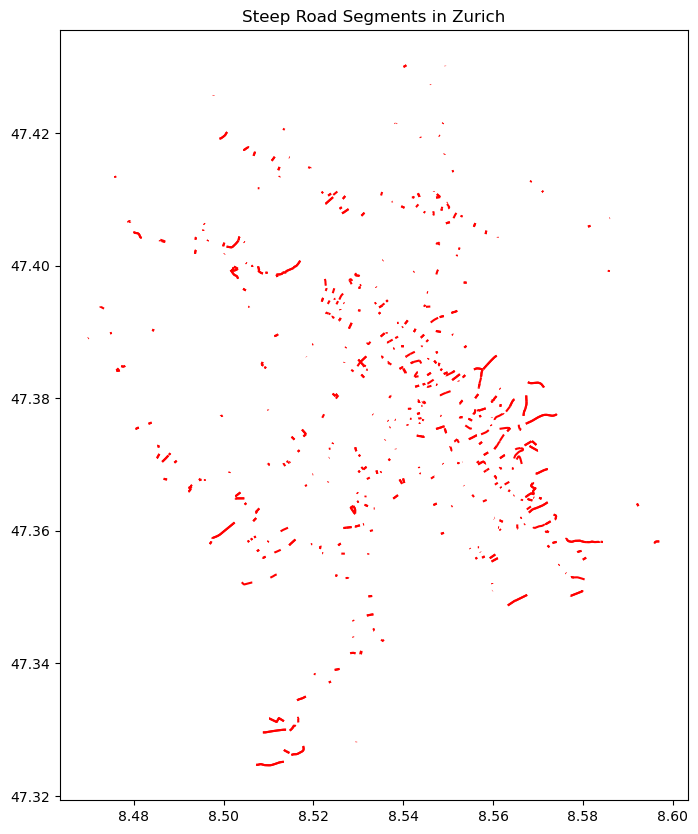

In [19]:
steep = edges[edges['abs_grade'] > 0.1]  # 10% grade
steep.plot(color='red', figsize=(10,10))
plt.title("Steep Road Segments in Zurich")

In [20]:
import numpy as np

def plot_elevation_profile(G, u, v):
    path = nx.shortest_path(G, u, v, weight='length')
    elevations = [G.nodes[n]['elevation'] for n in path]
    distances = [0] + [nx.shortest_path_length(G, path[i], path[i+1], weight='length') for i in range(len(path)-1)]
    distances = np.cumsum(distances)
    
    plt.plot(distances, elevations)
    plt.title("Elevation Profile")
    plt.xlabel("Distance (m)")
    plt.ylabel("Elevation (m)")
    plt.show()

In [21]:
import os
from osmnx import elevation

# File path to the DEM you downloaded
dem_path = 'baguio.tif'  # or zurich.tif

# Load the graph (make sure you've already created G_ph or G_eu)
G = G_ph  # or G_eu

# Add elevation to graph nodes
G = elevation.add_node_elevations_raster(G, dem_path)

# Optional: compute edge grades (slopes)
G = elevation.add_edge_grades(G)

# An elevation profile of a random road in Baguio

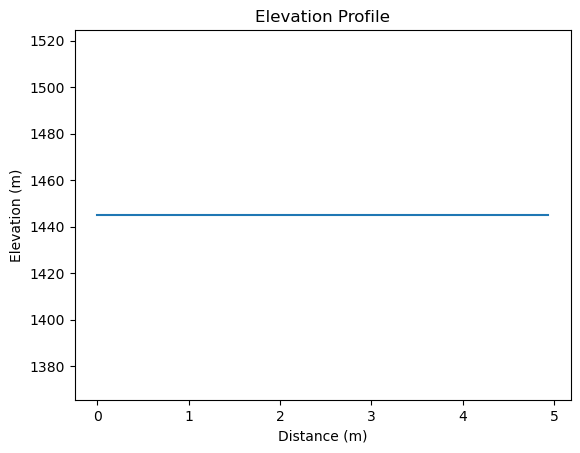

In [22]:
edge = ox.graph_to_gdfs(G, nodes=False).reset_index().iloc[0]
u = edge['u']
v = edge['v']

plot_elevation_profile(G, u, v)

# A longer road's elevation profile

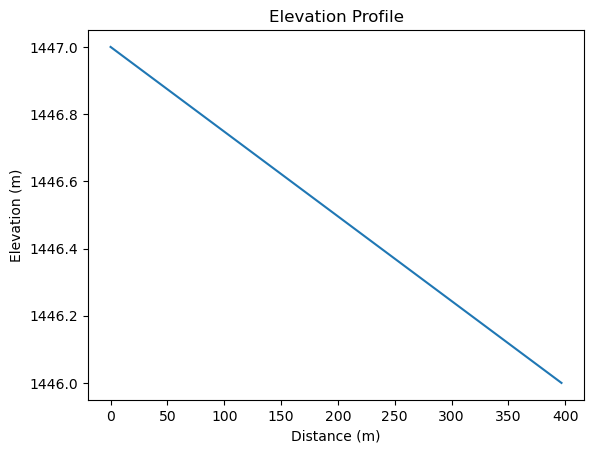

In [23]:
# option 1: longer road
edges = ox.graph_to_gdfs(G_ph, nodes=False).reset_index()
long_edges = edges[edges['length'] > 300]  # adjust threshold

# Pick a long edge
edge = long_edges.iloc[0]
u = edge['u']
v = edge['v']

plot_elevation_profile(G_ph, u, v)

# Kennon Road Elevation Profile

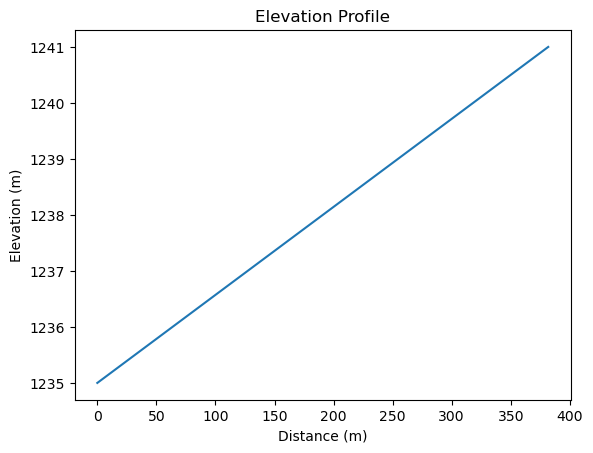

In [24]:
# option 2: steep road (kennon)
steep = edges[(edges['name'].str.contains("Kennon", na=False)) & (edges['length'] > 300)]

edge = steep.iloc[0]
u = edge['u']
v = edge['v']

plot_elevation_profile(G_ph, u, v)

# Intersection Density per km²

In [25]:
# Load the graphs
G_ph = ox.graph_from_place("Baguio, Benguet, Philippines", network_type='drive')
G_eu = ox.graph_from_place("Zurich, Switzerland", network_type='drive')

# Project to UTM for accurate area/distance calculations
G_ph_proj = ox.project_graph(G_ph)
G_eu_proj = ox.project_graph(G_eu)

In [26]:
# Get nodes and edges as GeoDataFrames
nodes_ph, edges_ph = ox.graph_to_gdfs(G_ph_proj)
nodes_eu, edges_eu = ox.graph_to_gdfs(G_eu_proj)

In [27]:
# Area in square meters
area_ph = nodes_ph.unary_union.convex_hull.area
area_eu = nodes_eu.unary_union.convex_hull.area

# Convert to km²
area_ph_km2 = area_ph / 1e6
area_eu_km2 = area_eu / 1e6

C:\Users\franj\AppData\Local\Temp\ipykernel_21832\1962986123.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_ph = nodes_ph.unary_union.convex_hull.area
C:\Users\franj\AppData\Local\Temp\ipykernel_21832\1962986123.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_eu = nodes_eu.unary_union.convex_hull.area


In [28]:
# Only nodes with 3 or more connecting streets
intersections_ph = nodes_ph[nodes_ph['street_count'] >= 3]
intersections_eu = nodes_eu[nodes_eu['street_count'] >= 3]

# Count
n_intersections_ph = len(intersections_ph)
n_intersections_eu = len(intersections_eu)

In [29]:
density_ph = n_intersections_ph / area_ph_km2
density_eu = n_intersections_eu / area_eu_km2

print(f"Baguio - Intersections/km²: {density_ph:.2f}")
print(f"Zurich - Intersections/km²: {density_eu:.2f}")

Baguio - Intersections/km²: 43.39
Zurich - Intersections/km²: 39.12


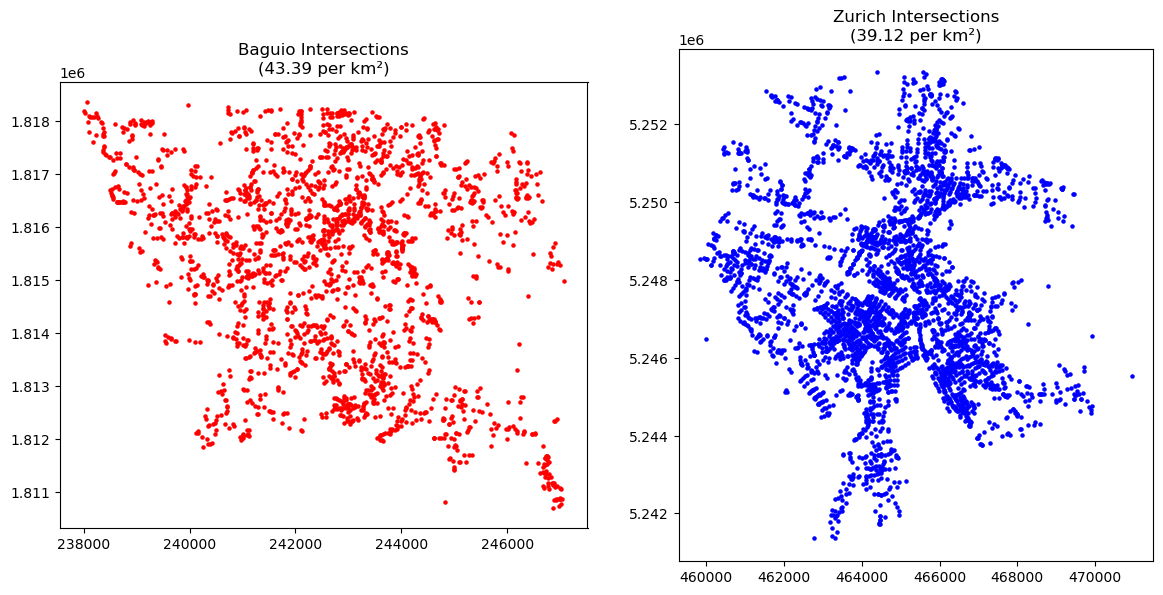

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

intersections_ph.plot(ax=ax[0], markersize=5, color='red')
ax[0].set_title(f"Baguio Intersections\n({density_ph:.2f} per km²)")

intersections_eu.plot(ax=ax[1], markersize=5, color='blue')
ax[1].set_title(f"Zurich Intersections\n({density_eu:.2f} per km²)")

plt.tight_layout()
plt.show()

In [31]:
# Define highway types and colors
highway_colors = {
    'motorway': 'red',
    'trunk': 'orange',
    'primary': 'gold',
    'secondary': 'green',
    'tertiary': 'blue',
    'residential': 'gray',
    'service': 'black',
    'unclassified': 'purple',
    'living_street': 'pink',
    'track': 'brown',
    'path': 'cyan'
}

def preprocess_and_clean_edges(G):
    edges = ox.graph_to_gdfs(G, nodes=False)

    # Normalize highway column
    edges['highway'] = edges['highway'].apply(
        lambda x: x[0] if isinstance(x, list) else x
    )

    # Drop rows with missing or non-plottable geometry
    edges = edges[edges.geometry.notnull() & edges.geometry.is_valid]
    edges = edges[edges['highway'].notnull()]

    return edges

In [32]:
def plot_road_hierarchy_from_edges(edges, title, ax):
    for hwy_type, color in highway_colors.items():
        subset = edges[edges['highway'] == hwy_type]
        if not subset.empty:
            subset.plot(ax=ax, color=color, linewidth=1, label=hwy_type)

    ax.set_title(title, fontsize=14)
    ax.axis('off')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=8)

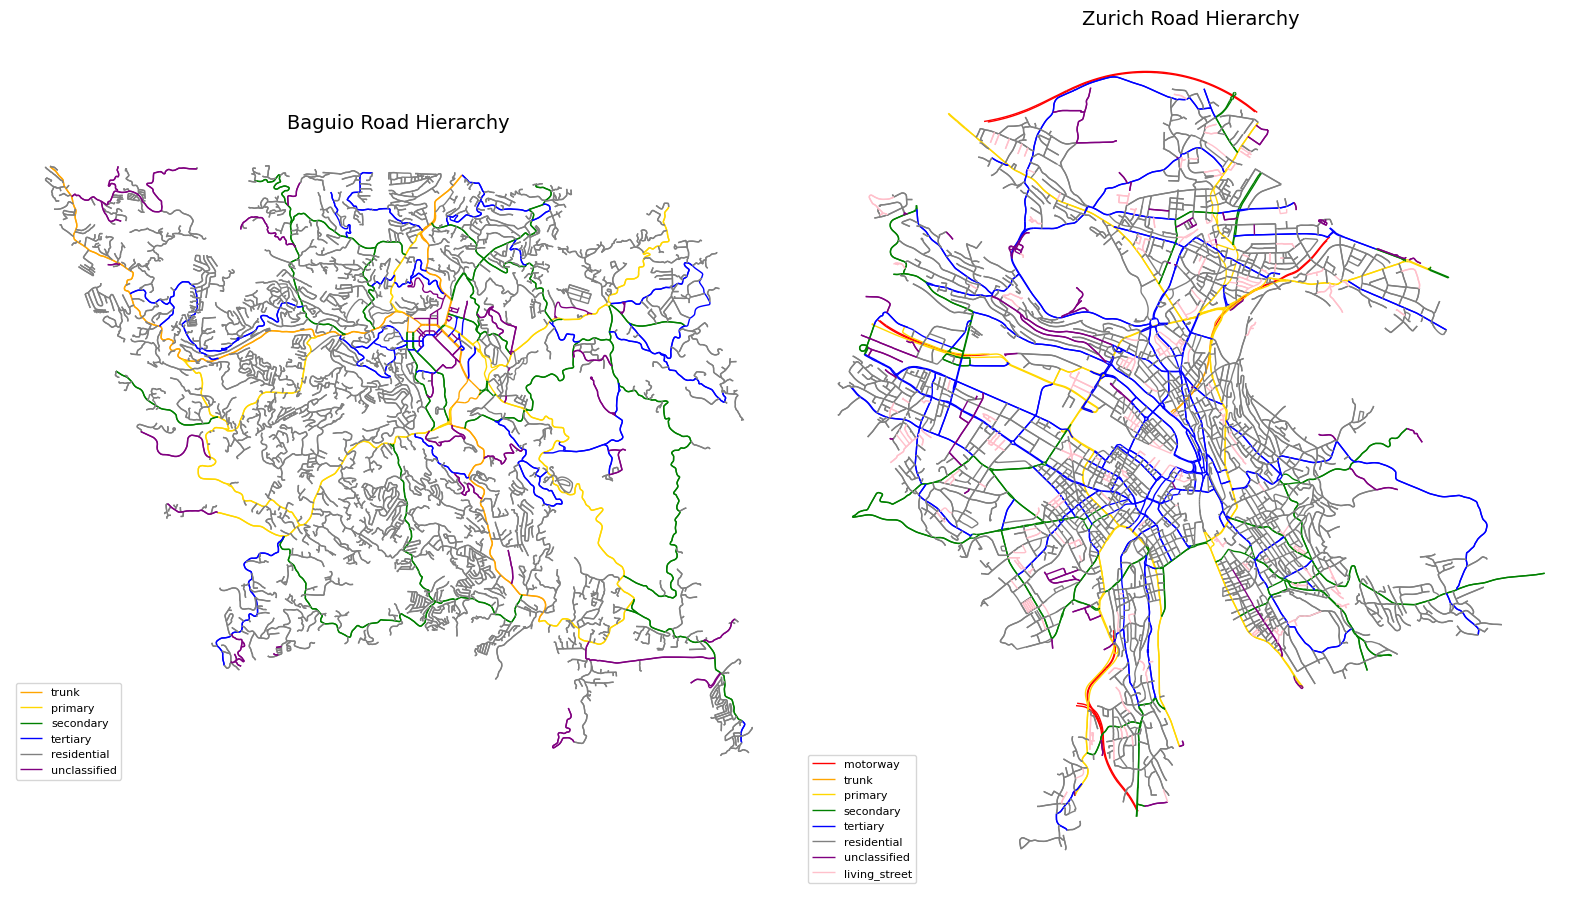

In [33]:
# Preprocess edges
edges_ph = preprocess_and_clean_edges(G_ph)
edges_eu = preprocess_and_clean_edges(G_eu)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
plot_road_hierarchy_from_edges(edges_ph, "Baguio Road Hierarchy", axs[0])
plot_road_hierarchy_from_edges(edges_eu, "Zurich Road Hierarchy", axs[1])
plt.tight_layout()
plt.show()

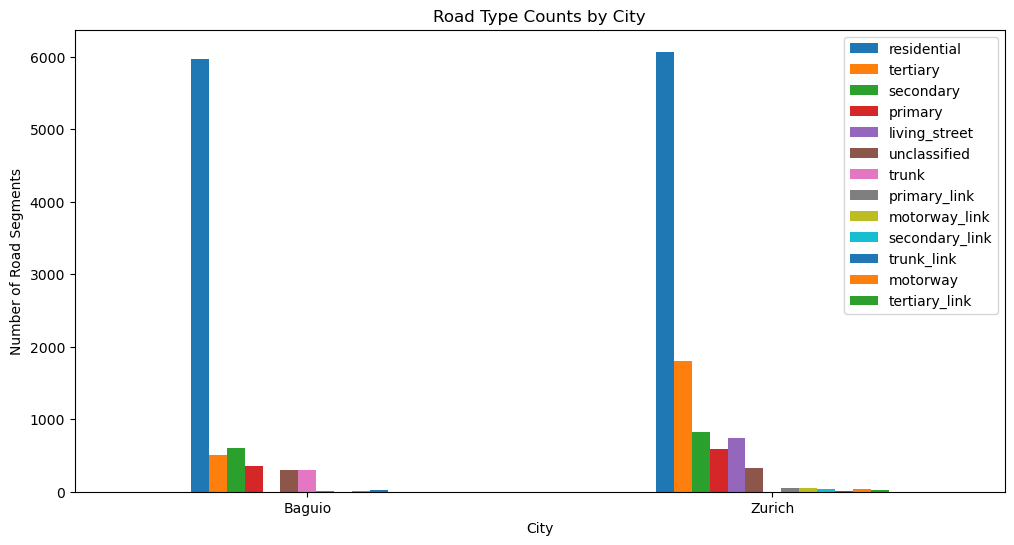

In [34]:
def highway_type_counts(G):
    highway_counts = {}
    for u, v, data in G.edges(data=True):
        # highway tag can be a list or string, handle both
        highway = data.get('highway')
        if isinstance(highway, list):
            highway = highway[0]  # take first if multiple
        if highway:
            highway_counts[highway] = highway_counts.get(highway, 0) + 1
    return highway_counts

counts_ph = highway_type_counts(G_ph)
counts_eu = highway_type_counts(G_eu)

# Convert to DataFrame for easier plotting
df = pd.DataFrame([counts_ph, counts_eu], index=['Baguio', 'Zurich']).fillna(0)

# Sort columns by total counts descending for cleaner plot
df = df[df.sum(axis=0).sort_values(ascending=False).index]

df.plot(kind='bar', figsize=(12,6))
plt.title('Road Type Counts by City')
plt.ylabel('Number of Road Segments')
plt.xlabel('City')
plt.xticks(rotation=0)
plt.show()

# Compare the Curvature of Classified Roads

In [35]:
from shapely.geometry import LineString

def calculate_curvature(edge):
    if not isinstance(edge['geometry'], LineString):
        return np.nan

    geom = edge['geometry']
    length = geom.length  # actual length (in degrees — will be converted later)
    
    # Get the straight-line distance between start and end point
    start = geom.coords[0]
    end = geom.coords[-1]
    
    # Euclidean distance (in degrees, roughly valid over small distances)
    straight = np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)

    if straight == 0:
        return 0  # perfectly straight
    else:
        return length / straight

In [36]:
# Convert the graphs to GeoDataFrames
edges_ph = ox.graph_to_gdfs(G_ph, nodes=False, edges=True)
edges_eu = ox.graph_to_gdfs(G_eu, nodes=False, edges=True)

# Apply curvature function
edges_ph['curvature'] = edges_ph.apply(calculate_curvature, axis=1)
edges_eu['curvature'] = edges_eu.apply(calculate_curvature, axis=1)

In [37]:
# If highway is a list, take the first value
edges_ph['highway'] = edges_ph['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)
edges_eu['highway'] = edges_eu['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [38]:
curv_by_type_ph = edges_ph.groupby('highway')['curvature'].mean().sort_values(ascending=False)
curv_by_type_eu = edges_eu.groupby('highway')['curvature'].mean().sort_values(ascending=False)

curv_df = pd.DataFrame({
    'Baguio': curv_by_type_ph,
    'Zurich': curv_by_type_eu
}).dropna()

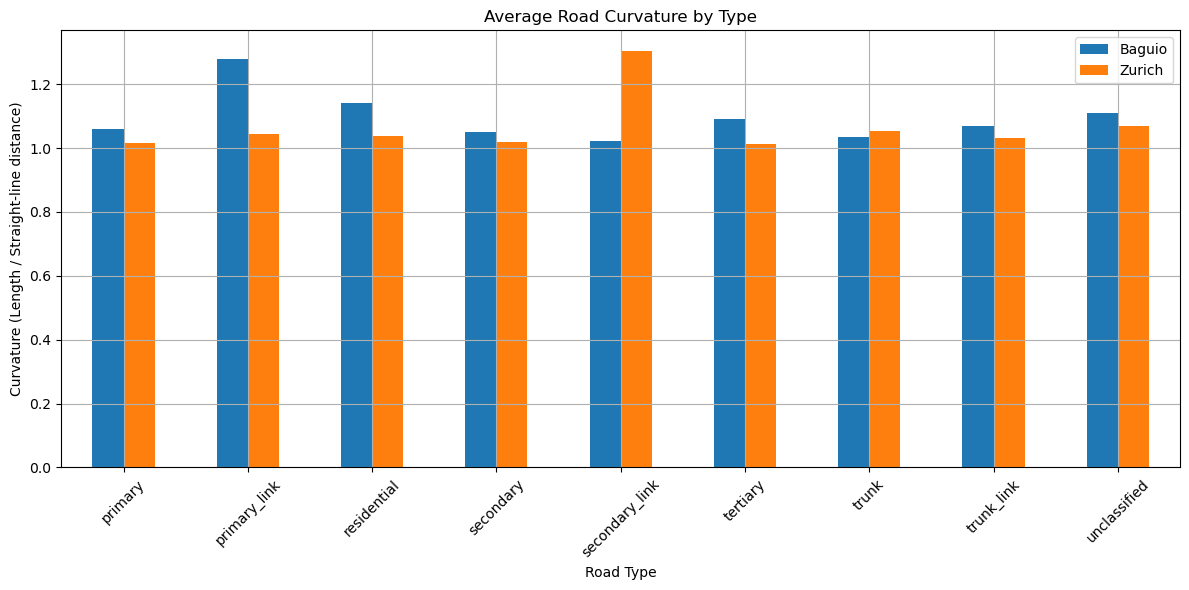

In [39]:
curv_df.plot(kind='bar', figsize=(12, 6), title='Average Road Curvature by Type')
plt.ylabel('Curvature (Length / Straight-line distance)')
plt.xlabel('Road Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# import osmnx as ox
# import geopandas as gpd

# def download_and_save_roads(place_name, save_path):
#     # Download drivable road network
#     G = ox.graph_from_place(place_name, network_type="drive")

#     # Convert to GeoDataFrame with edges
#     gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

#     # Only keep necessary columns, and reset index to save cleanly
#     columns_to_keep = ['highway', 'geometry']
#     gdf_edges = gdf_edges[columns_to_keep]
#     gdf_edges = gdf_edges.reset_index(drop=True)

#     # Save as gpkg
#     gdf_edges.to_file(save_path, driver='GPKG')
#     print(f"Saved: {save_path}")

# # Example usage
# download_and_save_roads("Baguio, Philippines", "baguio_roads.gpkg")
# download_and_save_roads("Zurich, Switzerland", "zurich_roads.gpkg")

c:\Users\franj\micromamba\envs\road-design\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
c:\Users\franj\micromamba\envs\road-design\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Cannot find tms_NZTM2000.json (GDAL_DATA is not defined)
  ogr_write(


Saved: baguio_roads.gpkg
Saved: zurich_roads.gpkg


In [ ]:
# import geopandas as gpd

# gdf = gpd.read_file(
#     "C:/Users/franj/notebooks/road design/gpkg_exports/baguio_roads.gpkg",
#     layer="baguio_roads"
# )

# print(gdf.columns)  # you should now see 'highway', 'lanes', etc.

Index(['highway', 'geometry'], dtype='object')
